[View in Colaboratory](https://colab.research.google.com/github/kundajelab/ssvmimp/blob/master/lsgkm.ipynb)

In [1]:
#install lsgkm
!rm -r lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 193 (delta 48), reused 48 (delta 23), pack-reused 111
Receiving objects: 100% (193/193), 425.08 KiB | 6.97 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread

Usage: gkmtrain [options] <posfile> <negfile> <outprefix>

 train gkm-SVM using libSVM

Arguments:
 posfile: positive sequence file (FASTA format)
 negfile: negative sequence file (FASTA format)
 outprefix: prefix of output file(s) <outprefix>.model.txt or
           

In [2]:
#get the raw data
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz

--2018-10-04 22:00:42--  https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.09s   

2018-10-04 22:00:42 (6.99 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]



In [3]:
!zcat sequences.simdata | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [0]:
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "1") {print ">$F[0]\n$F[1]"}' > positives.fa
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "0") {print ">$F[0]\n$F[1]"}' > negatives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' positives.fa > test_positives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' positives.fa > train_positives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' negatives.fa > test_negatives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' negatives.fa > train_negatives.fa

In [5]:
!wc -l *.fa

  12000 negatives.fa
   4000 positives.fa
   2400 test_negatives.fa
    800 test_positives.fa
   9600 train_negatives.fa
   3200 train_positives.fa
  32000 total


In [6]:
import time

t=3
c=10
g=2
l=6
k=4
d=2

!lsgkm/src/gkmtrain -t $t -c $10 -g $2 -l $l -k $k -d $d -w 3 train_positives.fa train_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3"


start = time.time()
!lsgkm/src/gkmpredict test_positives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))

INFO 2018-10-04 22:00:51: Number of threads is set to 1
INFO 2018-10-04 22:00:51: Arguments:
INFO 2018-10-04 22:00:51:   posfile = train_positives.fa
INFO 2018-10-04 22:00:51:   negfile = train_negatives.fa
INFO 2018-10-04 22:00:51:   outprefix = params_t3_l6_k4_d2_g2_c10_w3
INFO 2018-10-04 22:00:51: Parameters:
INFO 2018-10-04 22:00:51:   kernel-type = 3
INFO 2018-10-04 22:00:51:   L = 6
INFO 2018-10-04 22:00:51:   k = 4
INFO 2018-10-04 22:00:51:   d = 2
INFO 2018-10-04 22:00:51:   gamma = 2
INFO 2018-10-04 22:00:51:   C = 10
INFO 2018-10-04 22:00:51:   w = 3
INFO 2018-10-04 22:00:51:   eps = 0.001
INFO 2018-10-04 22:00:51:   shrinking = no
INFO 2018-10-04 22:00:51: reading 1600 sequences from train_positives.fa
INFO 2018-10-04 22:00:51: reading... 0
INFO 2018-10-04 22:00:51: reading... 1000
INFO 2018-10-04 22:00:51: reading... done
INFO 2018-10-04 22:00:51: reading 4800 sequences from train_negatives.fa
INFO 2018-10-04 22:00:51: reading... 0
INFO 2018-10-04 22:00:51: reading... 1000


In [10]:
import time
model_file = "params_t"+str(t)+"_l"+str(l)+"_k"+str(k)+"_d"+str(d)+"_g"+str(g)+"_c"+str(c)+"_w3.model.txt"

!head $model_file

start = time.time()
!lsgkm/src/gkmexplain test_positives.fa $model_file explanation_positives.txt
end = time.time()

impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("explanation_positives.txt")
]


svm_type c_svc
kernel_type gkmrbf
L 6
k 4
d 2
gamma 2
nr_class 2
total_sv 4151
rho 2.53961
label 1 -1


-0.20952402267000014


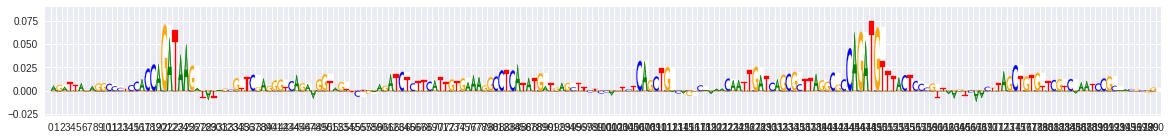

0.2535008994000001


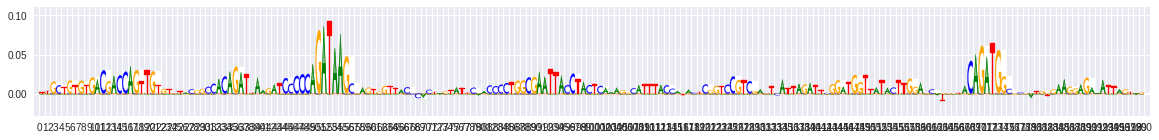

0.6256199229999999


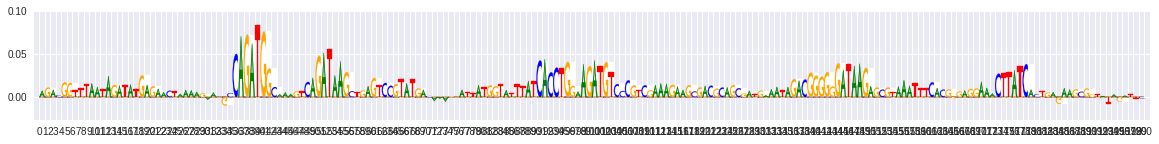

0.4501469348599998


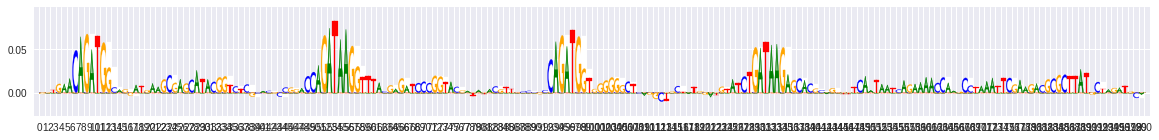

-0.2613947090000006


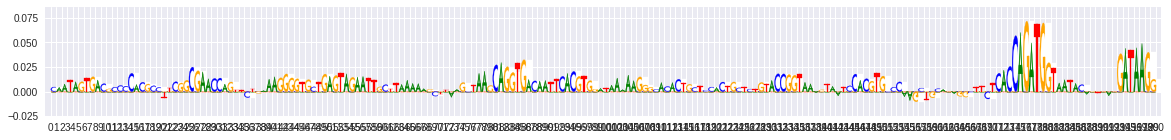

0.6717600504100001


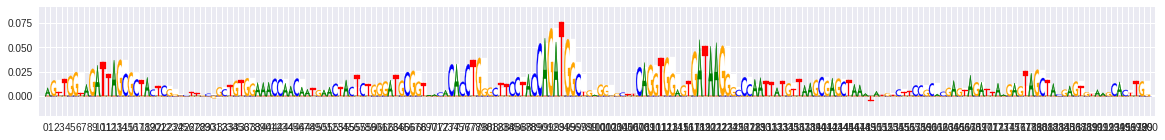

0.03464366379000028


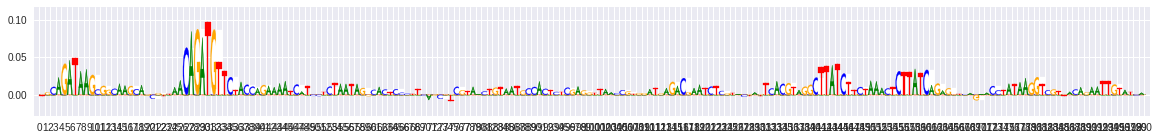

-0.3556897726999999


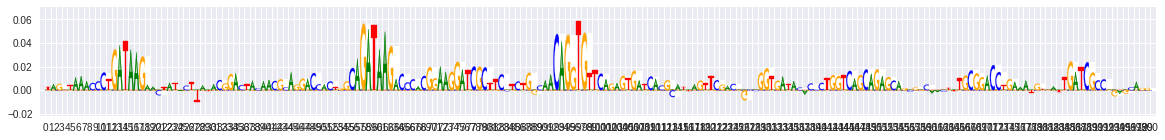

0.6449784890000001


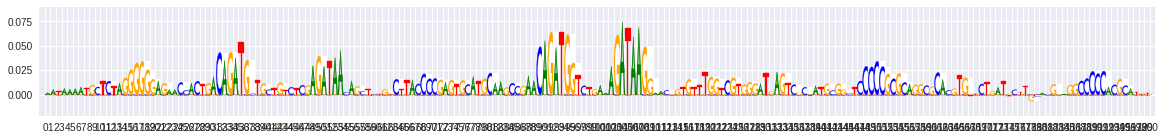

-0.9891733347


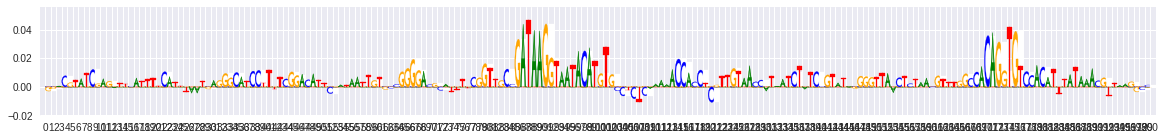

In [11]:
!pip install deeplift

from deeplift.visualization import viz_sequence
for i in range(10):
  print(np.sum(impscores[i]) - 2.53961)
  viz_sequence.plot_weights(impscores[i])


In [0]:

def run_ism(model_file_path,sequence,temp_filepath):
  
  letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3, 'N': -1}
  
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  fh.close()
  explanation_file = temp_filepath+".explanation.txt"
  !lsgkm/src/gkmexplain $temp_filepath $model_file_path $explanation_file
  
  gkmexplain_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explanation_file)
  ][0]

  
  seq_len = len(sequence)
  fh = open(temp_filepath,'w')
  mutated_seqs = []
  seq_names = []
  
  onehot_seq = np.zeros((seq_len,4))  
  for pos in range(seq_len):
    orig_letter_idx = letter_to_idx[sequence[pos]]
    if (orig_letter_idx != -1):
      onehot_seq[pos,orig_letter_idx] = 1
    for letter in ['A','C','G','T']:
      letter_idx = letter_to_idx[letter]
      fh.write(">pos-"+str(pos)+"_base-"+str(letter_idx)+"\n")
      fh.write(sequence[:pos]+letter+sequence[pos+1:]+"\n")
  fh.close()
  
  predictions_file = temp_filepath+".preds.txt"
  !lsgkm/src/gkmpredict $temp_filepath $model_file_path $predictions_file
    
  ism_importance_scores = np.zeros((seq_len,4))
  for line in open(predictions_file):
    seq_name,pred = line.rstrip().split("\t")
    pred = float(pred)
    pos,letter_idx = seq_name.split("_")
    pos = int(pos.split("-")[1])
    letter_idx = int(letter_idx.split("-")[1])
    ism_importance_scores[pos,letter_idx] = pred
  
  !rm $temp_filepath
  !rm $predictions_file
  !rm $explanation_file
  
  ism_hyp_importance_scores = ism_importance_scores-np.mean(ism_importance_scores,axis=1)[:,None]
  ism_importance_scores = ism_hyp_importance_scores*onehot_seq
  
  return ism_importance_scores, ism_hyp_importance_scores, gkmexplain_impscores
  


INFO 2018-10-04 22:14:11: Number of threads is set to 1
INFO 2018-10-04 22:14:11: load model params_t3_l6_k4_d2_g2_c10_w3.model.txt
INFO 2018-10-04 22:14:11: reading... 1000/4151
INFO 2018-10-04 22:14:12: reading... 2000/4151
INFO 2018-10-04 22:14:12: reading... 3000/4151
INFO 2018-10-04 22:14:12: reading... 4000/4151
INFO 2018-10-04 22:14:12: write prediction result to tmp.explanation.txt
INFO 2018-10-04 22:14:13: 1 scored
INFO 2018-10-04 22:14:13: Number of threads is set to 1
INFO 2018-10-04 22:14:13: test log
INFO 2018-10-04 22:14:13: load model params_t3_l6_k4_d2_g2_c10_w3.model.txt
INFO 2018-10-04 22:14:13: reading... 1000/4151
INFO 2018-10-04 22:14:13: reading... 2000/4151
INFO 2018-10-04 22:14:14: reading... 3000/4151
INFO 2018-10-04 22:14:14: reading... 4000/4151
INFO 2018-10-04 22:14:14: write prediction result to tmp.preds.txt
INFO 2018-10-04 22:14:16: 100 scored
INFO 2018-10-04 22:14:17: 200 scored
INFO 2018-10-04 22:14:18: 300 scored
INFO 2018-10-04 22:14:20: 400 scored
IN

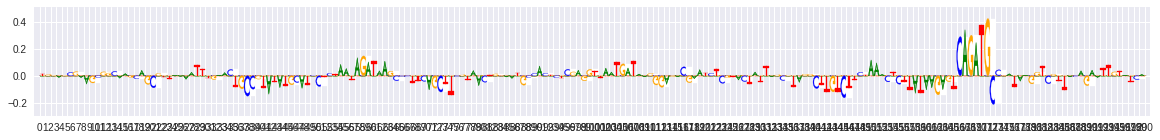

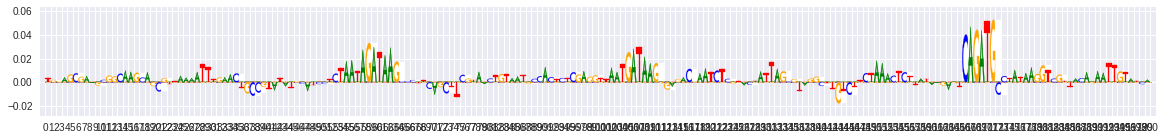

In [19]:
import time
#idx = 6
#the_seq = test_pos_seqs[idx]
the_seq = "TGGAGCGAAGCGGCAAGCAGCGTTAAAATTTGAACTGCCGTATATGCATCCTCTAATAGATAAGCCCTTCAGCTTCGTAACTGTAATGCCACTCTCGAGGTTAATGATAAGGGAGACGAATCTCGTACTATTAGCGTAGGCTTGTCTTCTAAACTCTTATAAGAGTCAGATGCCTATAAGGTCGTTACAGAATTGTATCA"


start = time.time()
ism_scores, ism_hyp_imp_scores, gkmexplain_scores = run_ism(model_file_path=model_file,
        sequence=the_seq, temp_filepath="tmp")
print(time.time()-start)

viz_sequence.plot_weights(ism_scores)
viz_sequence.plot_weights(gkmexplain_scores)

In [0]:
!python lsgkm/scripts/nrkmers.py 6 kmers.fa

In [21]:
!lsgkm/src/gkmpredict kmers.fa $model_file preds_kmers.txt

INFO 2018-10-04 22:15:18: Number of threads is set to 1
INFO 2018-10-04 22:15:18: test log
INFO 2018-10-04 22:15:18: load model params_t3_l6_k4_d2_g2_c10_w3.model.txt
INFO 2018-10-04 22:15:18: reading... 1000/4151
INFO 2018-10-04 22:15:19: reading... 2000/4151
INFO 2018-10-04 22:15:19: reading... 3000/4151
INFO 2018-10-04 22:15:19: reading... 4000/4151
INFO 2018-10-04 22:15:19: write prediction result to preds_kmers.txt
INFO 2018-10-04 22:15:19: 100 scored
INFO 2018-10-04 22:15:20: 200 scored
INFO 2018-10-04 22:15:20: 300 scored
INFO 2018-10-04 22:15:20: 400 scored
INFO 2018-10-04 22:15:20: 500 scored
INFO 2018-10-04 22:15:20: 600 scored
INFO 2018-10-04 22:15:20: 700 scored
INFO 2018-10-04 22:15:20: 800 scored
INFO 2018-10-04 22:15:20: 900 scored
INFO 2018-10-04 22:15:20: 1000 scored
INFO 2018-10-04 22:15:20: 1100 scored
INFO 2018-10-04 22:15:20: 1200 scored
INFO 2018-10-04 22:15:20: 1300 scored
INFO 2018-10-04 22:15:20: 1400 scored
INFO 2018-10-04 22:15:20: 1500 scored
INFO 2018-10-04

In [0]:
deltasvm_kmer_to_pred = {}
rc_trans = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
for line in open("preds_kmers.txt"):
  kmer,pred = line.rstrip().split("\t")
  pred = float(pred)
  deltasvm_kmer_to_pred[kmer] = pred
  deltasvm_kmer_to_pred["".join([rc_trans[x] for x in kmer[::-1]])] = pred

In [0]:
sorted_kmers = sorted(deltasvm_kmer_to_pred.items(),
                      key=lambda x: -x[1])

In [24]:
sorted_kmers[:10]

[('CACCTG', -1.6328),
 ('CAGGTG', -1.6328),
 ('CTAATC', -1.8288),
 ('GATTAG', -1.8288),
 ('CCCCCC', -1.91259),
 ('GGGGGG', -1.91259),
 ('ATTAGG', -1.93073),
 ('CCTAAT', -1.93073),
 ('CACCAG', -1.93164),
 ('CTGGTG', -1.93164)]

In [0]:
#!pip install shap

import shap
import numpy as np
import sys

def onehot_seq(seq):
  letter_to_index = {'A':0, 'a':0,
                     'C':1, 'c':1,
                     'G':2, 'g':2,
                     'T':3, 't':3}
  to_return = np.zeros((len(seq),4))
  for idx,letter in enumerate(seq):
    to_return[idx,letter_to_index[letter]] = 1
  return to_return

def get_shap_explanation(gkmsvm_model, seq, nsamples):
  
  index_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}

  def pred_func(onehot_seqs):
    onehot_seqs = onehot_seqs.reshape(len(onehot_seqs),-1,4)
    #convert the sequences to strings
    seqs = [ "".join([index_to_letter[x] for x in seq])
      for seq in np.argmax(onehot_seqs, axis=-1)]
    
    to_return = []
    for idx,x in enumerate(seqs):
      if (idx%10==0):
        print("Done",idx+1,"of",len(seqs))
        sys.stdout.flush()
      to_return.append(gkmsvm_model.compute_prediction(x))
    return np.array(to_return)
  
  explainer = shap.KernelExplainer(pred_func,
                                   np.zeros((1,len(seq)*4)))
  X_test = np.array([onehot_seq(seq)])
  shap_values = explainer.shap_values(X_test.reshape((len(X_test), -1)),
                                      nsamples=nsamples)
  shap_values = shap_values.reshape((-1,4))
  return shap_values


shap_explanation = get_shap_explanation(gkmsvm_model=gkm_svm_model,
                                         seq=the_seq,
                                         nsamples=len(the_seq)*4)

Done 1 of 1







  0%|          | 0/1 [00:00<?, ?it/s]

Done 1 of 1
Done 1 of 800
Done 11 of 800
Done 21 of 800
Done 31 of 800
Done 41 of 800
Done 51 of 800
Done 61 of 800
Done 71 of 800
Done 81 of 800
Done 91 of 800
Done 101 of 800
Done 111 of 800
Done 121 of 800
Done 131 of 800
Done 141 of 800
Done 151 of 800
Done 161 of 800


Done 171 of 800
Done 181 of 800
Done 191 of 800
Done 201 of 800
Done 211 of 800
Done 221 of 800
Done 231 of 800
Done 241 of 800
Done 251 of 800
Done 261 of 800
Done 271 of 800
Done 281 of 800
Done 291 of 800
Done 301 of 800
Done 311 of 800
Done 321 of 800
Done 331 of 800
Done 341 of 800
Done 351 of 800
Done 361 of 800
Done 371 of 800
Done 381 of 800
Done 391 of 800
Done 401 of 800
Done 411 of 800
Done 421 of 800
Done 431 of 800
Done 441 of 800
Done 451 of 800
Done 461 of 800
Done 471 of 800
Done 481 of 800
Done 491 of 800
Done 501 of 800
Done 511 of 800
Done 521 of 800
Done 531 of 800
Done 541 of 800
Done 551 of 800
Done 561 of 800
Done 571 of 800
Done 581 of 800
Done 591 of 800
Done 601 of 800
Done 611 of 800
Done 621 of 800
Done 631 of 800
Done 641 of 800
Done 651 of 800
Done 661 of 800
Done 671 of 800
Done 681 of 800
Done 691 of 800
Done 701 of 800
Done 711 of 800
Done 721 of 800
Done 731 of 800
Done 741 of 800
Done 751 of 800
Done 761 of 800
Done 771 of 800
Done 781 of 800
Done 791

100%|██████████| 1/1 [23:56<00:00, 1436.44s/it]


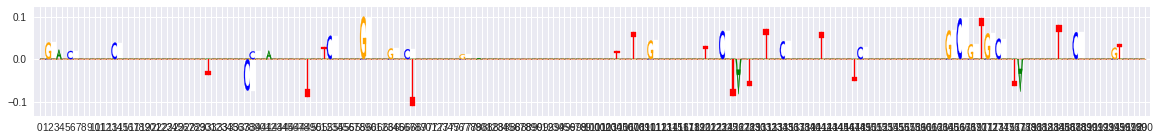

In [0]:
viz_sequence.plot_weights(shap_explanation)